In [1]:
import pandas as pd
import numpy as np
import sys,os
from tqdm import tqdm
sys.path.insert(0, '/home/shenwanxiang/Research/aliyun_sync/COMPASS/')
from baseline.immnue_score.scorer import ssGSEA

from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label,plot_performance, score2
from compass.tokenizer import CANCER_CODE, CONCEPT

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd
    

/home/shenwanxiang/anaconda3/envs/compass/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

def train_lgr_with_gridsearch(
    train_X, train_y,
    scoring='roc_auc', cv=10, n_jobs=-1, random_state=42):
    """
    1) GridSearchCV find best parameters
    2) best parameters for refit(train_X, train_y) 
    3) return: best_estimator_, best_params_, best_cv_score, final_model
    """
    # Build a pipeline: standardize -> logistic regression
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2", solver="lbfgs", class_weight="balanced",
            max_iter=1000, random_state=random_state
        ))
    ])

    # Param grid (only search C on the classifier step)
    param_grid = {
        "clf__C": np.logspace(-4, 1, 50)  # 
    }

    # Stratified CV for classification
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    gcv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        cv=skf,
        n_jobs=n_jobs,
        refit=True,          # refit pipeline on the whole train set using best params
        verbose=0
    )
    gcv.fit(train_X, train_y)

    best_params = gcv.best_params_
    best_cv_score = gcv.best_score_
    # best_estimator = gcv.best_estimator_   # already refit on full train set

    # Optionally, extract best C for reporting
    best_C = best_params["clf__C"]

    print(f"[GridSearch] best_C={best_C:.3g}, best_{scoring}={best_cv_score:.4f}")

    # best_estimator is the final model trained on the full training data
    return gcv

In [3]:
df_label = pd.read_csv('./data/ITRP_clinical.csv', index_col=0)
s = df_label.cohort.value_counts()
large_medium_cohorts = s[s  > 30].index.tolist()

#df_label = df_label[df_label.cohort.isin(large_cohorts)]
cohort_list = df_label.cohort.unique().tolist()


In [4]:
cohort_map = s.index + '(n=' + s.astype(str) + ')'

In [5]:
y = onehot(df_label.response_label)

In [6]:
X1 = pd.read_csv('./data/ITRP_avg_concept_43.csv', index_col=0)
X3 = pd.read_csv('./data/ITRP_ssGSEA_concept_43.csv', index_col=0)
X0 = pd.read_csv('./data/ITRP_COMPASS_PT_44.csv', index_col=0)
X0 = X0[X0.columns[1:]]

X5 = pd.read_csv('./data/ITRP_avg_signature_132.csv', index_col=0)
X7 = pd.read_csv('./data/ITRP_ssGSEA_signature_132.csv', index_col=0)
X9 = pd.read_csv('./data/ITRP_COMPASS_PT_133.csv', index_col=0)
X9 = X9[X9.columns[1:]]

In [7]:
def leave_one_cohort_out(cohorts):
    # Create a list of lists, each missing one element from the original list
    return [(cohorts[i], cohorts[:i] + cohorts[i+1:]) for i in range(len(cohorts))]
train_test_cohorts = leave_one_cohort_out(cohort_list)

In [8]:
Modes = ['Geometric mean from Gene TPM', 
         'ssGSEA from Gene TPM', 
         'COMPASS(Encoder-Projector)'
        ]

levels = ['concepts', 'signatures']
Xs1 = [X1, X3, X0]
Xs2 = [X5, X7, X9]

In [9]:
final_performance = []


for level, Xs in zip(levels, [Xs1, Xs2]):
    for X, mode in zip(Xs, Modes):
        
        res = []
        for test_cohort, train_cohorts in train_test_cohorts:
    
            train_cohort_name = 'Leave_%s_out' % test_cohort
            ## Get data for this cohort
            cohort_idx = df_label[df_label['cohort'].isin(train_cohorts)].index
            cohort_X = X.loc[cohort_idx]
            cohort_y = y.loc[cohort_idx]
    
            train_X = cohort_X 
            train_y = cohort_y['R'].values
    
            test_cohort_idx = df_label[df_label['cohort'] == test_cohort].index
            test_cohort_X = X.loc[test_cohort_idx]

            test_cohort_y = y.loc[test_cohort_idx]['R']
    
            gcv = train_lgr_with_gridsearch(train_X, train_y)
            test_pred_prob = gcv.best_estimator_.predict_proba(test_cohort_X)
            dfp = pd.DataFrame(test_pred_prob, index =test_cohort_y.index )
    
            dfp['train_cohort'] = train_cohort_name
            dfp['test_cohort'] = test_cohort    
            dfp['best_C'] = gcv.best_params_["clf__C"]
            dfp['mode'] = mode
            
            dfp = dfp.join(test_cohort_y)
            y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
            
            res.append(dfp)
    
        dfs = pd.concat(res)
        dfp = dfs.groupby(['train_cohort', 'test_cohort']).apply(lambda x:score2(x['R'], x[1], x[[0, 1]].idxmax(axis=1)))
        mode_map = dfs.groupby('train_cohort')['mode'].unique().apply(lambda x:x[0])
        c_map = dfs.groupby('train_cohort')['best_C'].unique().apply(lambda x:x[0])
        
        #roc, prc, f1, acc, mcc
        dfp = dfp.apply(pd.Series)
        dfp.columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC']
        dfp = dfp.reset_index()
        dfp['mode'] = dfp.train_cohort.map(mode_map)
        dfp['best_C'] = dfp.train_cohort.map(c_map)
        dfp['level'] = level
        final_performance.append(dfp)

dfp = pd.concat(final_performance)

[GridSearch] best_C=0.0176, best_roc_auc=0.6703
[GridSearch] best_C=0.115, best_roc_auc=0.6773
[GridSearch] best_C=0.091, best_roc_auc=0.6833
[GridSearch] best_C=0.072, best_roc_auc=0.6868
[GridSearch] best_C=0.045, best_roc_auc=0.6892
[GridSearch] best_C=0.091, best_roc_auc=0.6896
[GridSearch] best_C=0.0281, best_roc_auc=0.6639
[GridSearch] best_C=0.146, best_roc_auc=0.6877
[GridSearch] best_C=0.072, best_roc_auc=0.6820
[GridSearch] best_C=0.115, best_roc_auc=0.6837
[GridSearch] best_C=0.045, best_roc_auc=0.6519
[GridSearch] best_C=0.0569, best_roc_auc=0.6908
[GridSearch] best_C=0.184, best_roc_auc=0.6972
[GridSearch] best_C=0.072, best_roc_auc=0.6846
[GridSearch] best_C=0.0356, best_roc_auc=0.6815
[GridSearch] best_C=0.072, best_roc_auc=0.6742
[GridSearch] best_C=0.0281, best_roc_auc=0.6722
[GridSearch] best_C=0.754, best_roc_auc=0.6823
[GridSearch] best_C=0.0569, best_roc_auc=0.6859
[GridSearch] best_C=0.0569, best_roc_auc=0.6885
[GridSearch] best_C=0.045, best_roc_auc=0.6921
[GridS

In [10]:
df1 = pd.read_csv('../../04_model_performance/02_leave_one_cohort_out/conceptor_run/LOCO_a100/LOCO_PFT_24/metric_performance.tsv', 
            sep = '\t', index_col=0)
df1['mode'] = 'COMPASS'
df1['seed'] = 24
df2 = pd.read_csv('../../04_model_performance/02_leave_one_cohort_out/conceptor_run/LOCO_a100/LOCO_PFT_42/metric_performance.tsv', 
            sep = '\t', index_col=0)
df2['mode'] = 'COMPASS'
df2['seed'] = 42
df3 = pd.read_csv('../../04_model_performance/02_leave_one_cohort_out/conceptor_run/LOCO_a100/LOCO_PFT_64/metric_performance.tsv', 
            sep = '\t', index_col=0)
df3['mode'] = 'COMPASS'
df3['seed'] = 64

In [58]:
pd.concat([df1,df2,df3]).groupby('test_cohort').ACC.mean().loc[large_medium_cohorts].mean()

0.7251650035770231

In [47]:
pd.concat([df1,df2,df3]).groupby('test_cohort').PRC.mean().loc[large_medium_cohorts].median()

0.6719695113973652

In [39]:
dfp = pd.concat(final_performance)
dfp.to_csv('./results/COMPASS_ssGSEA_mean_performance.csv', sep = '\t')

In [50]:
dfp1 = [dfp.test_cohort.isin(large_medium_cohorts)]

In [56]:
dfp1.groupby(['level','mode']).ACC.mean().unstack().T

level,concepts,signatures
mode,,
COMPASS(Encoder-Projector),0.667123,0.648065
Geometric mean from Gene TPM,0.593707,0.578912
ssGSEA from Gene TPM,0.592663,0.590106


In [42]:
roc = dfp1.groupby(['level','mode', 'test_cohort']).ROC.mean().unstack().T
roc = roc.loc[large_medium_cohorts].round(3)
roc.index = roc.index.map(cohort_map)
roc_mean = roc.mean().to_frame(name='Mean').T
roc_std = roc.std().to_frame(name='Mean').T
roc_mean = roc_mean.round(3).astype(str) + '±' + roc_std.round(3).astype(str)
roc = roc.round(3).astype(str)._append(roc_mean)
roc.to_excel('./results/COMPASS_GLM_ssGSEA_ROC.xlsx')

In [43]:
roc

level                                concepts                               \
mode               COMPASS(Encoder-Projector) Geometric mean from Gene TPM   
IMVigor210(n=298)                       0.696                        0.642   
IMmotion150(n=165)                      0.743                        0.705   
Liu(n=107)                              0.674                         0.59   
SU2CLC1(n=102)                          0.784                         0.65   
Rose(n=89)                              0.717                        0.767   
Gide(n=73)                              0.831                        0.761   
Riaz(n=51)                              0.707                        0.544   
Kim(n=45)                                0.96                        0.927   
Allen(n=39)                             0.888                        0.663   
MGH(n=34)                               0.773                        0.693   
Mean                              0.777±0.092                  0.694±0.107   

level                                                   signatures  \
mode               ssGSEA from Gene TPM COMPASS(Encoder-Projector)   
IMVigor210(n=298)                 0.637                      0.712   
IMmotion150(n=165)                0.662                       0.69   
Liu(n=107)                        0.613                      0.712   
SU2CLC1(n=102)                     0.66                      0.752   
Rose(n=89)                        0.744                      0.782   
Gide(n=73)                        0.782                      0.839   
Riaz(n=51)                         0.58                      0.737   
Kim(n=45)                         0.939                      0.939   
Allen(n=39)                       0.675                      0.787   
MGH(n=34)                         0.655                      0.742   
Mean                        0.695±0.104                0.769±0.074   

level                                                                 
mode               Geometric mean from Gene TPM ssGSEA from Gene TPM  
IMVigor210(n=298)                         0.658                0.656  
IMmotion150(n=165)                        0.722                0.705  
Liu(n=107)                                 0.54                0.543  
SU2CLC1(n=102)                            0.665                0.654  
Rose(n=89)                                0.743                0.729  
Gide(n=73)                                0.768                0.798  
Riaz(n=51)                                0.583                0.593  
Kim(n=45)                                 0.912                0.904  
Allen(n=39)                               0.642                0.642  
MGH(n=34)                                 0.716                0.697  
Mean                                0.695±0.104          0.692±0.103

In [44]:
prc = dfp.groupby(['level','mode', 'test_cohort']).PRC.mean().unstack().T
prc = prc.loc[large_medium_cohorts].round(3)
prc.index = prc.index.map(cohort_map)
prc_mean = prc.mean().to_frame(name='Mean').T
prc_std = prc.std().to_frame(name='Mean').T
prc_mean = prc_mean.round(3).astype(str) + '±' + prc_std.round(3).astype(str)
prc = prc.round(3).astype(str)._append(prc_mean)
prc.to_excel('./results/COMPASS_GLM_ssGSEA_PRC.xlsx')

In [19]:
prc

level                                concepts                               \
mode               COMPASS(Encoder-Projector) Geometric mean from Gene TPM   
IMVigor210(n=298)                       0.459                        0.316   
IMmotion150(n=165)                      0.615                        0.451   
Liu(n=107)                              0.571                        0.503   
SU2CLC1(n=102)                          0.737                        0.483   
Rose(n=89)                              0.356                        0.375   
Gide(n=73)                              0.848                        0.823   
Riaz(n=51)                              0.383                        0.241   
Kim(n=45)                               0.879                        0.852   
Allen(n=39)                             0.862                        0.531   
MGH(n=34)                               0.711                        0.663   
Mean                              0.642±0.197                  0.524±0.203   

level                                                   signatures  \
mode               ssGSEA from Gene TPM COMPASS(Encoder-Projector)   
IMVigor210(n=298)                 0.308                      0.431   
IMmotion150(n=165)                0.437                      0.594   
Liu(n=107)                        0.523                       0.58   
SU2CLC1(n=102)                    0.501                      0.715   
Rose(n=89)                        0.367                      0.453   
Gide(n=73)                        0.831                      0.874   
Riaz(n=51)                        0.243                       0.48   
Kim(n=45)                         0.899                      0.792   
Allen(n=39)                       0.528                      0.741   
MGH(n=34)                         0.648                       0.68   
Mean                        0.528±0.213                0.634±0.151   

level                                                                 
mode               Geometric mean from Gene TPM ssGSEA from Gene TPM  
IMVigor210(n=298)                         0.327                0.314  
IMmotion150(n=165)                        0.452                0.444  
Liu(n=107)                                0.459                 0.47  
SU2CLC1(n=102)                            0.529                0.519  
Rose(n=89)                                0.329                0.313  
Gide(n=73)                                0.817                0.838  
Riaz(n=51)                                0.243                0.248  
Kim(n=45)                                 0.793                0.825  
Allen(n=39)                               0.526                0.524  
MGH(n=34)                                 0.687                0.682  
Mean                                0.516±0.197          0.518±0.208

In [78]:
palette = ['#F6C6AD', '#E59EDD', '#61CBF4']

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

signatures_ssGSEA from Gene TPM vs. signatures_COMPASS(Encoder-Projector): Wilcoxon test (paired samples), P_val:2.136e-04 Stat=4.000e+00
concepts_ssGSEA from Gene TPM vs. concepts_COMPASS(Encoder-Projector): Wilcoxon test (paired samples), P_val:2.139e-02 Stat=2.400e+01
signatures_Geometric mean from Gene TPM vs. signatures_COMPASS(Encoder-Projector): Wilcoxon test (paired samples), P_val:2.136e-03 Stat=1.200e+01
concepts_Geometric mean from Gene TPM vs. concepts_COMPASS(Encoder-Projector): Wilcoxon test (paired samples), P_val:1.825e-02 Stat=2.300e+01


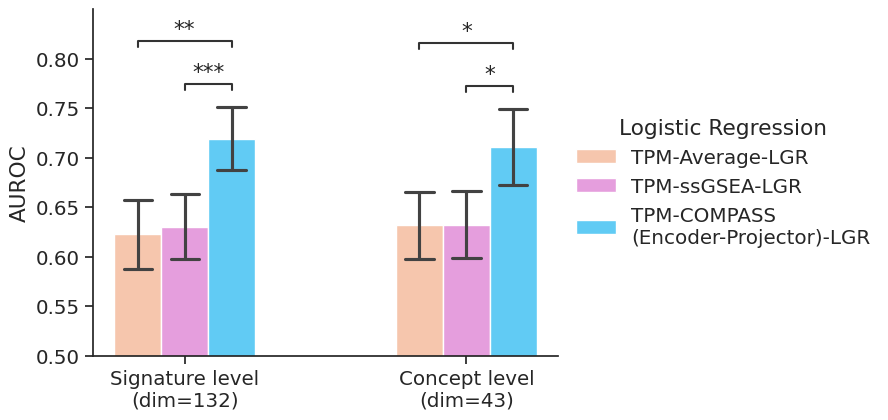

In [79]:
from statannotations.Annotator import Annotator

x='level'
y='ROC'
hue = 'mode'
labels =  ['TPM-Average-LGR',
           'TPM-ssGSEA-LGR',
          'TPM-COMPASS\n(Encoder-Projector)-LGR',      
          ]

order = ['signatures', 'concepts']
x_labelticks = ['Signature level\n(dim=132)', 'Concept level\n(dim=43)']
width = 0.5

fig, ax = plt.subplots(figsize=(6, 4.5), )
sns.barplot(data  = dfp1, x = x, errorbar = 'se', hue= hue,order = order,saturation = 1,
            hue_order = Modes, capsize=0.3, width = width, palette=palette,
            #legend=False,
            y = y, ax=ax)

ax.set_ylim(0.5, 0.8)
ax.set_ylabel('AUROC')
ax.set_xlabel('')
sns.despine()

ax.tick_params(bottom=True, left=True)


handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, labels,
           title="Logistic Regression", 
           loc='center left',        
           bbox_to_anchor=(1.0, 0.5), 
           frameon=False)

ax.set_xticklabels(x_labelticks, rotation = 0)


pairs = [
         (('concepts', 'ssGSEA from Gene TPM'),
          ('concepts','COMPASS(Encoder-Projector)')),
         (('concepts', 'Geometric mean from Gene TPM'),
          ('concepts','COMPASS(Encoder-Projector)')),

         
         (('signatures', 'ssGSEA from Gene TPM'),
          ('signatures','COMPASS(Encoder-Projector)')),
         (('signatures', 'Geometric mean from Gene TPM'),
          ('signatures','COMPASS(Encoder-Projector)')),
        ]

annot = Annotator(
    ax, pairs,
    data=dfp, x = x, y = y, hue = hue,
    order = order, hue_order = Modes, width = width, 
    # DO NOT pass plot='barplot'
)
annot.configure(
    test='Wilcoxon',                 # or 'Mann-Whitney'
    #comparisons_correction='fdr_bh',
    text_format='star',
    show_test_name=False
)
annot.apply_and_annotate()

fig.savefig(f'./results/LGR_ROC_barplot.svg',
            bbox_inches = 'tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

signatures_ssGSEA from Gene TPM vs. signatures_COMPASS(Encoder-Projector): Wilcoxon test (paired samples), P_val:2.136e-03 Stat=1.200e+01
concepts_ssGSEA from Gene TPM vs. concepts_COMPASS(Encoder-Projector): Wilcoxon test (paired samples), P_val:1.550e-02 Stat=2.200e+01
signatures_Geometric mean from Gene TPM vs. signatures_COMPASS(Encoder-Projector): Wilcoxon test (paired samples), P_val:4.272e-04 Stat=6.000e+00
concepts_Geometric mean from Gene TPM vs. concepts_COMPASS(Encoder-Projector): Wilcoxon test (paired samples), P_val:1.550e-02 Stat=2.200e+01


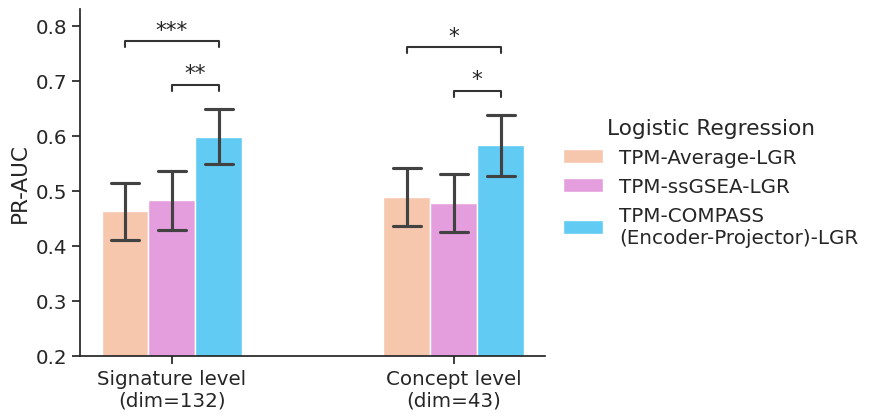

In [80]:
y='PRC'

fig, ax = plt.subplots(figsize=(6, 4.5), )
sns.barplot(data  = dfp1, x = x, errorbar = 'se', hue= hue,order = order,
            hue_order = Modes, capsize=0.3, width = width, palette=palette,saturation = 1,
            #legend=False,
            y = y, ax=ax)

ax.set_ylim(0.2, 0.75)
ax.set_ylabel('PR-AUC')
ax.set_xlabel('')
sns.despine()

ax.tick_params(bottom=True, left=True)


handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, labels,
           title="Logistic Regression", 
           loc='center left',        
           bbox_to_anchor=(1.0, 0.5), 
           frameon=False)

ax.set_xticklabels(x_labelticks, rotation = 0)


annot = Annotator(
    ax, pairs,
    data=dfp, x = x, y = y, hue = hue,
    order = order, hue_order = Modes, width = width, 
    # DO NOT pass plot='barplot'
)
annot.configure(
    test='Wilcoxon',  
    #paired=True,  # or 'Mann-Whitney'
    #comparisons_correction='fdr_bh',
    text_format='star',
    show_test_name=True
)
annot.apply_and_annotate()


fig.savefig(f'./results/LGR_PRC_barplot.svg',
            bbox_inches = 'tight')